In [ ]:
import function

from pymongo import MongoClient
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from datetime import datetime
from time import sleep

import warnings
warnings.filterwarnings("ignore")

import config

from IPython.display import HTML
import random

client = MongoClient(config.mongo_db)

# 1. Выгрузка данных
В этом разделе были выполнены действия по выгрузке нужных нам данных с датчиков конкретных процессов и рецептов. Представлен список всех выбранных процессов и отброшены процессы с неполными данными.

In [ ]:
series_good = list(set(['83210820','83110320','83210820','83100320','83210820','83100220',
                       '83220920','83100220','83220920','83100220','83220920']))

series_bad = list(set(['83110320','83110619','83130719','83050220','83110619','83050220','83110619','83130719','83100619',
                      '83120719','83150719','83150719','83120719','83150719','83150719','83120719','83150719']))

vessel = '2000L'

list_sensor = ['sens_5_pv',
               'tcu_1_pv',
               'sens_9_pv',
               'sens_1_pv',
               'sens_2_pv',
               'sens_39_pv',
               'sens_40_pv',
               'sens_7_pv',
               'sens_3_pv',
               'sens_4_pv',
               'sens_38_pv',
               'sens_11_pv',
               'sens_12_pv',
               'sens_13_pv',
               'sens_14_pv',
               'sens_15_pv',
               'sens_16_pv',
               'pump_3_pv',
               'pump_4_pv',
               'pump_5_pv',
               'pump_6_pv',
               'mixer_1_pv',]

train = ['83110320***SUB 2000L Vessel#8',
         '83210820***SUB 2000L Vessel#8',
         '83100320***SUB 2000L Vessel#9',
         '83210820***SUB 2000L Vessel#9',
         '83100220***SUB 2000L Vessel#10',
         '83100220***SUB 2000L Vessel#11',
         '83220920***SUB 2000L Vessel#11',
         '83100220***SUB 2000L Vessel#12',
         '83220920***SUB 2000L Vessel#12',]

goods_add = ['83220920***SUB 2000L Vessel#10','83210820***SUB 2000L Vessel#7']

goods = ['83110320***SUB 2000L Vessel#8','83210820***SUB 2000L Vessel#8','83100320***SUB 2000L Vessel#9','83220920***SUB 2000L Vessel#10','83210820***SUB 2000L Vessel#7']

bads = ['83130719***SUB 2000L Vessel#7',
        '83150719***SUB 2000L Vessel#10', 
        '83110619***SUB 2000L Vessel#8', 
        '83130719***SUB 2000L Vessel#9', 
        '83150719***SUB 2000L Vessel#11']
function.hide_toggle()

In [ ]:
df_good = function.get_df(series_good, vessel, list_sensor)

In [ ]:
df_bad = function.get_df(series_bad, vessel, list_sensor)

In [ ]:
bad = df_bad[df_bad['seria'].isin(bads)]
bad = bad.drop([1,5,15,18], axis = 0)
trn = df_good[df_good['seria'].isin(train)]
proc = bad.append(trn,ignore_index = True)
good = df_good[df_good['seria'].isin(goods_add)]
good = good.drop(1, axis = 0)
proc = proc.append(good, ignore_index = True).reset_index(drop=True)
proc

# 2. Преобработка данных
В этом разделе была выполнена предподготовка данных, отсеянны неподходящие датчики убраны пропуски, сокращена размерность данных до 2-х в соотвествии с ТЗ, выполнена стандартизация. 

In [ ]:
# Посчитать константные столбцы
list_const_col = []
for i in proc.index:
    list_const_col.append(function.constant_feature_detect(proc['data'][i], 0.99))

In [ ]:
# Возьмем и посмотрим на cписок констант
list_const_col

In [ ]:
# Отбросить неподходящие столбцы
for i in proc.index:
    proc['data'][i] = proc['data'][i].drop(['Датчик расхода кислорода O2-2','Датчик углекислого газа pCO2-1','Датчик pH-2',
                                            'Датчик расхода углекислого газа CO2-1','Насос 3','Насос 4','Насос 5','Насос 6',
                                            'Датчик расхода кислорода O2-1', 'Сенсор накопленного расхода щелочи', 'Датчик кислорода dO2-1'], axis = 1)

In [ ]:
# Заменить NULL на np,nan, первести все во float.
col = proc['data'][i].columns[1:]
for i in proc.index:
    proc['data'][i] = proc['data'][i].replace('NULL', None)
    proc['data'][i][col[0]] = proc['data'][i][col[0]].astype(float)
    proc['data'][i].fillna(proc['data'][i].mean(), inplace = True)

In [ ]:
# Проверить что порядок столбцов и их кол-во одинаково  во всех процессах
for i in range(len(proc)-1):
    diff = proc['data'][i].columns == proc['data'][i+1].columns
    print(set(diff), i,'-', i+1)

In [ ]:
# Синхронизировать время
proc['transform'] = ''
for i in proc.index:
    proc['transform'][i] = proc['data'][i].drop('TM', axis = 1).values.reshape(1,-1)[0]
    print(i)

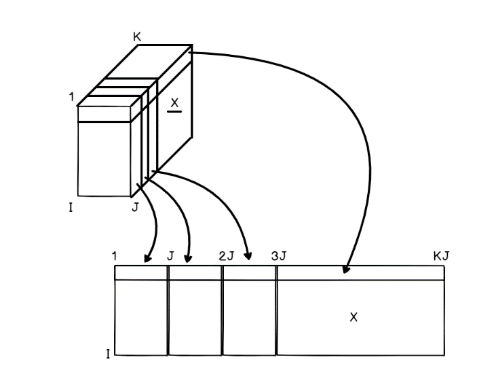

In [ ]:
# Находим наименьшее число строк и обрезаем по этому процессу
min_len =  float("inf")

for x in proc['transform']:
    min_len = min(min_len, len(x))
    

train_proc = proc[proc['seria'].isin(train)].copy(deep=True)
test_proc = proc[proc['seria'].isin(bads)].copy(deep=True)
test_proc = test_proc.append(proc[proc['seria'].isin(goods).copy(deep=True)], ignore_index = True).reset_index()


list_for_matrix = []
for x in train_proc['transform']:
    list_for_matrix.append(x[0:min_len])
    train_matrix = np.array(list_for_matrix)
    
list_for_matrix = []
for x in test_proc['transform']:
    list_for_matrix.append(x[0:min_len])
    test_matrix = np.array(list_for_matrix)   
    
count_str = train_matrix.shape[0]
count_columns = train_matrix.shape[1]
min_len

In [ ]:
# Почему то конлфикты при работе, переведем все матрицы в float
train_matrix = train_matrix.astype(float)
test_matrix = test_matrix.astype(float)
# Стандартизируем матрицы
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std_train_matrix = scaler.fit_transform(train_matrix)
std_test_matrix = scaler.transform(test_matrix)

In [ ]:
for row in range(count_str):
    for el in range(count_columns):
        if std_train_matrix[row,el] == 0:
            std_train_matrix[row,el] = 0.00001
            
            
for row in range(0,1):
    for el in range(count_columns):
        if std_test_matrix[row,el] == 0:
            std_test_matrix[row,el] = 0.00001

# 3. NIPLAS
В этом разделе выполнено разложение нашей общей матрицы данных, на 2 матрицы меньше, **нагрузок (p-loads)** (нужной нам для дальнейшего преобразования данных) и **счетов (t-scores)** непосредственно представление данных в новом векторном пространстве. Построен график зависимости доли восстановления данных от количества главных компонент.

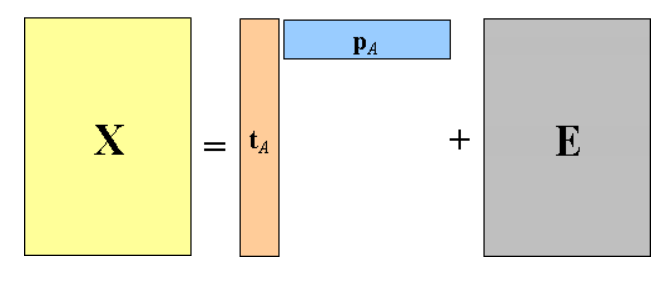

In [ ]:
sum_X = sum(sum(std_train_matrix**2))
list_E = []
for i in range(1,10):
    temp = function.NIPALS(std_train_matrix, i)
    list_E.append(1-(sum(sum(temp['E'] ** 2)) / sum_X))
plt.plot(range(1, 10), list_E)
plt.title('Зависимость доли объясненных значений от колличества главных компонент')
plt.xlabel("Колличество главных компонент")
plt.ylabel("Доля объясненных значений")

#### Что происходит на этом графике:
Этот график предназначен для первичной оценки нужного нам количества главных компонент, здесь по оси Х мы видим количество главных компонент, а по оси Y доля объяснённых значений $1-\frac{\sum{E^2}}{\sum{X^2}}$, здесь $\sum{E^2}$ сумма квадратов ошибок, $\sum{X^2}$ сумма квадратов значений изначальной матрицы. Слишком большое количество главных компонент переобучат наш алгоритм под конкретную выборку, а слишком малое не позволит адекватно восстановить наш исходный тренировочный набор данных. Выбор пал на количество главных компонент равной 100. Ниже представлено точное значение доли объясненных данных, а так же сумма ошибок по всей матрице, и наконец сравнение восстановленной матрицы данных с ее изначальным видом, при 100 главных компонентах.

In [ ]:
# ПРименим функцию на тренировочной выборке (колличество главных компонент определим по колличеству процессов)
result_component = function.NIPALS(std_train_matrix, 7)
print(f'Доля объясненных данных при количестве главных компонент равному {6+1} = ', round(list_E[6],2),'%',sep = '')
# Высчитаем получившеюся матрицу
train_matrix_PCA = np.dot(result_component['t'],result_component['p'].T)
# Посмотрим на сумму ошибок 
print('Значение Е^2',sum(sum(result_component['E']**2)))
print('Доля ошибок:',sum(sum(result_component['E']**2))/sum(sum(std_train_matrix**2)))

In [ ]:
# Сравним матрицы
print('Изначальная матрица', '\n', std_train_matrix)
print('Измененная матрица', '\n', train_matrix_PCA)

# 4. Рассчет статистик и отрисовка графиков
В этом разделе был выполнен расчет статистик согласно ТЗ (**Q** статистики и статистики по **t счета**), результаты отображены на графиках. $Q_i = \sum{E_i^2}$

In [ ]:
F_7_1_005 = 236.7684
F_7_1_001 = 5928.356

F_2_7_005 = 4.7374
F_2_7_001 = 9.547

Q, Q_005, Q_001, D, T2_005, T2_001, S_005, S_001 = function.count_statistic(result_component['t'], result_component['E'], F_7_1_005, F_7_1_001, F_2_7_005, F_2_7_001)

In [ ]:
proc.set_index(proc['seria'], inplace = True)
label = train_proc['seria']
function.plot_Q2(Q, Q_005, Q_001, label)

#### Что происходит на этом графике:
Здесь представлены значения квадрата ошибок $Q^2$ по каждому процессу, а также рассчитанные для этого Q статистики 0.05 и 0.01 доверительного интервалов. В сущности этот график показывает какой из процессов алгоритм смог восстановить плохо, а какой хорошо в соответствии с этим можно сделать вывод, является ли конкретный процесс отклонение либо он похож на предыдущие.

In [ ]:
function.plot_Tscore(result_component['t'],S_005,S_001, num = 5)

#### Что происходит на этих графиках:
На этих графиках отображены попарные представления первых 5 главных компонент, близость данных, представленных в этих координатах, может говорить нам, о том насколько эти процессы похожи или различаются между собой. Другими словами, чем ближе друг к другу точки, тем более вероятность что процесс не отличается от других, чем дальше тем хуже, также в ней можно увидеть в каком из главных компонент происходит вылет.

# 5. Применение алгоритма на тестовых данных
В этом разделе был выполнен эксперимент по опробации алгоритма для ранее неизвестных данных, в тренировочной выборке находятся 5 заведомо "плохих" серий:

83130719*\*\*\SUB 2000L Vessel#7    

83150719\*\*\*SUB 2000L Vessel#10

83110619\*\*\*SUB 2000L Vessel#8

83130719\*\*\*SUB 2000L Vessel#9

83150719\*\*\*SUB 2000L Vessel#11

5 "хороших" серий состоящих из 3 находящихся в тренировочной выборке:

83110320\*\*\*SUB 2000L Vessel#8

83210820\*\*\*SUB 2000L Vessel#8

83100320\*\*\*SUB 2000L Vessel#9

и две новых для алгоритма серий:

83220920\*\*\*SUB 2000L Vessel#10

83210820\*\*\*SUB 2000L Vessel#7


In [ ]:
def pipline(df, p_matrix):
    
    data = np.array(df[0:min_len])
    
    data = data.reshape(1,-1)
    
    data = data.astype(float)

    data = scaler.transform(data)
    
    t_matrix = data @ p_matrix
    E = data - t_matrix @ p_matrix.T
    Q = np.sum(E**2,axis=1)
    
    
    matrix_PCA = np.dot(t_matrix,p_matrix.T)
    print('Значение Е^2',sum(sum(E**2)))
    
    
    return t_matrix, E, Q

In [ ]:
test_df = test_proc[test_proc['seria'] == goods[4]]['transform'].values[0]
t_new, E, Q = pipline(test_df,result_component['p'])

In [ ]:
function.plot_Q2(Q, Q_005, Q_001, [goods[2]])

In [ ]:
test_df = test_proc[test_proc['seria'] == bads[0]]['transform'].values[0]
t_new, E, Q = pipline(test_df,result_component['p'])

In [ ]:
function.plot_Q2(Q, Q_005, Q_001, [bads[0]])

In [ ]:
t_matrix = std_test_matrix @ result_component['p']
E = std_test_matrix - t_matrix @ result_component['p'].T
Q = np.sum(E**2,axis=1)
matrix_PCA = np.dot(t_matrix,result_component['p'].T)
print('Значение Е^2',sum(sum(E**2)))

In [ ]:
label = test_proc['seria'].values
function.plot_Q2(Q, Q_005, Q_001, label)

Видно что первые 4 процесса (которые являются плохими) выходят сильно вперед, да так сильно что на графиках остальные и не видно, отобразим значениях квадрата их ошибок в таблицу:

In [ ]:
pd.DataFrame(np.round(Q,2).reshape(-1,1), index = list(test_proc.seria), columns = ['E^2'])

Здесь первые 5 это ошибки явно "плохих" процессов и видно что они измеряются примерно в миллиардах и сотнях тысяч, а последние 5 это явно хорошие, причем ожидаемо что тренировочные данные показывают совсем небольшие значения ошибок, а новые показывают значения ошибок равные десяткам тысяч. Таким образом алгоритм смог ретроспективно  отделить (хоть и апеллируя слишком большими значениями ошибок) какие процессы протекали хорошо, а какие плохо.

Кроме того, значения квадрата ошибок полученных, при подача процесса по 1 и всего множества сразу совпали, а значит алгоритм способен адекватно оценивать как 1 так и сразу множество процессов.

Перейдем теперь к анализу t-score статистик, ниже будет представлен график представления test в координатах новых 3 и 4 главной компонент (так как они вышли наиболее подходящими для демонстрации, на других тоже видно но не так отчетливо):

In [ ]:
function.plot_Tscore(t_matrix,S_005,S_001, num = 5)

Здесь можно наблюдать 5 наиболее близких к друг другу процессов, другие же 5 находится далеко от них, это означает что в представлениях полученных нами главных компонент 5 "хороших" процессов лежат очень близко друг к другу и могут принадлежать к одному кластеру (как раз то что нам надо), а 5 других являются своего рода выбросами лежат очень далеко друг от друга и не образуют кластеров.

Подводя итоги можно сказать, что в первом приближении при недостаточности данных алгоритм неплохо справился с поставленной задачей, значения ошибок хоть и велики, но значимо отличимые для хороших и плохих серий вне тренировочной выборки. На графиках t-score статистик хорошо видно кластер "хороших" процессов. Для дальнейшего исследования алгоритма и целесообразности его применения а практике, нужно собрать больше данных по процессам, и провести еще ряд экспериментов подобных этому.